In [1]:
import collections
import json
import os
import re
import time

import ahocorasick
import networkx as nx
import openai
import pandas as pd
import pdfplumber
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt

dataDir = "../data/"
dataName = "Deep Learning.pdf"

# 设置 api


In [2]:
# openai.api_base = "https://api.chatanywhere.com.cn/"
openai.api_base = "https://api.chatanywhere.cn/"
openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"

# 一，读取数据


## 生成目录架构

- 生成**章节名称**与**章节序号**的对应：`name_dict`
- 以及**章节序号**与**章节页码**范围的对应：`index_dict`


In [3]:
with pdfplumber.open(dataDir + dataName) as f:
    # 目录架构生成
    c, p, n = [], [], []
    for i in range(7):
        page = f.pages[i]
        text = page.extract_text()
        text_split = text.split("\n")
        for i in text_split:
            if bool(re.match("[0-9]+\.[0-9]+", i.split(" ")[0])):
                c.append(i.split(" ")[0])
                p.append(int(i.split(" ")[-1]) + 15)
            if bool(re.match("[0-9]+", i.split(" ")[0])):
                for j in i.split(" "):
                    if bool(re.match("[A-Za-z]+", j)):
                        n.append((i.split(" ")[0], j))

### name_dict


In [4]:
name_dict = {}
for i, j in n:
    if i in name_dict:
        name_dict[i] = name_dict.get(i, "") + " " + j
    else:
        name_dict[i] = name_dict.get(i, "") + j

### index_dict


In [5]:
p_range = list(zip(p, p[1:]))
p_range.append((735, 800))
c_p_range = list(zip(c, p_range))
index_dict = collections.defaultdict(list)
for k, v in c_p_range:
    index_dict[k.split(".")[0]].append((k, v))

## 生成内容表

- 段落内容表：`content_dict`


### content_dict

In [6]:
with pdfplumber.open(dataDir + dataName) as f:
    content_dict = collections.defaultdict(list)

    for k, v in index_dict.items():
        for i in v:
            page_range = i[-1]
            if page_range[0] == page_range[1]:
                page_range = (page_range[0], page_range[1] + 1)
            for j in range(int(page_range[0])-1, int(page_range[1])-1):
                page = f.pages[j]

                text = page.extract_text().replace("\n", " ")

                content_dict[i[0]].append(text)

# 二，抽取实体与关系

## GPT3.5

### 价格计算

In [7]:
def total_counts(response):
    tokens_nums = int(response["usage"]["total_tokens"])
    price = 0.003 / 1000
    cost = "{:.5f}".format(price * tokens_nums * 7.5)
    print(f"tokens: {tokens_nums}, cost: {cost}")

    return float(cost)

### 定义Chat

In [75]:
class Chat:
    def __init__(self, conversation_list=[]):
        self.conversation_list = conversation_list
        self.costs_list = []

    def show_conversation(self, msg_list):
        for msg in msg_list[-2:]:
            if msg["role"] == "user":
                pass
            else:
                message = msg["content"]
                pass
                # print(f"\U0001f47D: {message}\n")

    def ask(self, prompt):
        self.conversation_list.append({"role": "user", "content": prompt})
        openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-16k", messages=self.conversation_list
        )
        answer = response.choices[0].message["content"]

        self.conversation_list.append({"role": "assistant", "content": answer})
        self.show_conversation(self.conversation_list)

        cost = total_counts(response)
        self.costs_list.append(cost)
        return answer

### 设置prompt

In [76]:
NER_prompt = [
    "你是一个深度学习、机器学习、数学、计算机科学领域的实体标注专员，\
给定字符串，请找出全部深度学习、机器学习、数学、计算机科学领域的实体，\
以('entity1', 'entity2', ...)的格式返回，尽量遵循字符串中的原本表述。\
除返回结果外，不要返回任何其他内容。"
]

In [77]:
relations = "'based on', 'facet of', 'part of', 'instance of', 'subject of', 'subclass of', 'use'"

In [78]:
relation_prompt = [
    f"你是一个深度学习、机器学习、数学、计算机科学领域的关系抽取专员，\
给定关系列表({relations})，\
输入实体列表，请找出实体列表中存在关系的实体，\
并以('head', 'relation', 'tail')的格式返回所有三元组，\
请尽量不改变原实体的表述。\
除结果外，不要返回任何其他内容。\
如输入'LSTM, RNN'，返回('LSTM', 'instance of', 'RNN')"
]

### 模拟断点续传

In [67]:
content_dict_2 = {}
str_temp = "20.15"
page_temp = 23
j = float("inf")
for i, (k, v) in enumerate(content_dict.items()):
    if k == str_temp:
        j = i
    if i >= j:
        content_dict_2[k] = v

### 抽取关系

In [86]:
# for k, v in content_dict_2.items():
#     for page, content in enumerate(v):
#         if (k==str_temp and page>page_temp) or k!=str_temp:
#             if page % 5 == 0:
#                 conversation_list = [
#                     {
#                         "role": "system",
#                         "content": NER_prompt[0],
#                     }
#                 ]
#                 bot_ner = Chat(conversation_list)
#                 conversation_list = [
#                     {
#                         "role": "system",
#                         "content": relation_prompt[0],
#                     }
#                 ]

#                 bot_relation = Chat(conversation_list)
#             answer_ner = bot_ner.ask(content)
#             answer_relation = bot_relation.ask(answer_ner)
#             df = pd.DataFrame(
#                 [[k, page, answer_ner, answer_relation]],
#                 columns=["section", "page", "entity", "relation"],
#             )
#             df.to_csv(
#                 os.path.join(dataDir + "/relations", f"results_gpt3_5.csv"),
#                 mode="a",
#                 header=not os.path.exists(
#                     os.path.join(dataDir + "/relations", f"results_gpt3_5.csv")
#                 ),
#                 index=False,
#             )

tokens: 681, cost: 0.01532
tokens: 232, cost: 0.00522
tokens: 797, cost: 0.01793
tokens: 292, cost: 0.00657
tokens: 904, cost: 0.02034
tokens: 320, cost: 0.00720
tokens: 576, cost: 0.01296
tokens: 460, cost: 0.01035
tokens: 862, cost: 0.01940
tokens: 808, cost: 0.01818
tokens: 1480, cost: 0.03330
tokens: 1170, cost: 0.02633
tokens: 1865, cost: 0.04196
tokens: 1309, cost: 0.02945
tokens: 2589, cost: 0.05825
tokens: 1601, cost: 0.03602
tokens: 726, cost: 0.01634
tokens: 216, cost: 0.00486
tokens: 1319, cost: 0.02968
tokens: 309, cost: 0.00695
tokens: 2001, cost: 0.04502
tokens: 505, cost: 0.01136
tokens: 2626, cost: 0.05908
tokens: 644, cost: 0.01449
tokens: 3172, cost: 0.07137
tokens: 768, cost: 0.01728
tokens: 703, cost: 0.01582
tokens: 241, cost: 0.00542
tokens: 892, cost: 0.02007
tokens: 279, cost: 0.00628
tokens: 1549, cost: 0.03485
tokens: 427, cost: 0.00961
tokens: 2005, cost: 0.04511
tokens: 637, cost: 0.01433
tokens: 2669, cost: 0.06005
tokens: 878, cost: 0.01976
tokens: 395, co

# 三，Build Relations

## 目录 + 前置

In [14]:
def catalogue_relations(dataName, name_dict=None, relation_type=["目录", "前置"]):
    c_relations = []
    p_relations = []
    if not name_dict:
        name_dict = {}
    for k, v in name_dict.items():
        if bool(re.match("[0-9]+\.[0-9]+", k)):
            p_relations.append(
                [
                    k.split(".")[0] + " " + name_dict[k.split(".")[0]],
                    relation_type[1],
                    k + " " + v,
                ]
            )
        else:
            c_relations.append(
                [
                    dataName,
                    relation_type[0],
                    k + " " + v,
                ]
            )
    return p_relations, c_relations

In [15]:
p_relations, c_relations = catalogue_relations(
    dataName=dataName.split(".")[0], name_dict=name_dict
)

## 包含 + 共现 + 位置

### 读取关系

In [87]:
df = pd.read_csv(
    dataDir + "relations/" + "results_gpt3_5.csv",
    index_col=False,
    dtype={"section": str, "page": int},
)

In [88]:
# fix bugs

# df = pd.read_csv(
#     dataDir + "relations/" + "results_gpt3_5-Copy1.csv",
#     index_col=False,
#     dtype={"section": str, "page": int},
# )


# df["entity"] = df["entity"].shift(-14)
# df["relation"] = df["relation"].shift(-14)
# df = df.iloc[11:703, :]

# padding_dict = collections.defaultdict(list)
# for i, j in index_dict.items():
#     for page in j:
#         if page[1][0] == page[1][1]:
#             padding_dict["section"].append(page[0])
#             padding_dict["page"].append(0)
#             padding_dict["entity"].append(
#                 df[
#                     df["section"]
#                     == (
#                         page[0].split(".")[0]
#                         + "."
#                         + str(int(page[0].split(".")[1]) - 1)
#                     )
#                 ].iloc[-1]["entity"]
#             )
#             padding_dict["relation"].append(
#                 df[
#                     df["section"]
#                     == (
#                         page[0].split(".")[0]
#                         + "."
#                         + str(int(page[0].split(".")[1]) - 1)
#                     )
#                 ].iloc[-1]["relation"]
#             )
# padding_df = pd.DataFrame(padding_dict)

# df = df._append(padding_df, ignore_index=True)

# df.to_csv(
#     os.path.join(dataDir + "/relations", f"results_gpt3_5.csv"),
#     mode="w",
#     index=False,
# )

In [89]:
df["entity_list"] = df["entity"].apply(
    lambda x: re.sub("\(|\)|", "", x[2:-2]).split("', '")
)

In [90]:
df["relation_tuple"] = df["relation"].apply(
    lambda x: [re.findall(r"'(.*?)', '(.*?)', '(.*?)'", i) for i in x.split("\n")]
)

### 实体清理 

In [91]:
not_use_entity_set = {
    "matrix W",
    "sensor\\",
    "base distribution p(x)",
    "functions",
    "py|x",
    "ht",
    "α, β, β, f, φ, x, y, τ",
    "true θ",
    "All you need is a good init",
    "milestone",
    "px = x,y = y z = z",
    "class",
    "path",
    "Loop",
    "bytes",
    "Muja",
    "ICML’13' 'Goodfellow",
    "USA",
    "Caffe",
    "new drugs",
    "Amazon",
    "ph v",
    "update H 1g",
    "location",
    "house",
    "is less than",
    "Springer' 'Frasconi",
    "melody",
}
relations_set = {
    "based on",
    "facet of",
    "part of",
    "instance of",
    "subject of",
    "subclass of",
    "use",
    "used by",
    "method of",
    "measure of",
    " instance of",
    "algorithm for",
    "contains",
    "defined by",
    "includes",
    "is a",
}
pattern_list = [
    "(^([0-9]+|[A-Za-z])$)",  # 匹配纯数字或单个字母
    "(\\b[A-Z][a-z]*([-][A-Z][a-z]*)?,\s?[A-Z]([-][A-Z])?(\.[A-Z]?[-]?)*\.)",  # 匹配人名，如Rezende, D. J.和Wierstra, D.
    "(.*\(?\d{4}\)?)",  # 匹配以(年份)结尾的任意字符串
    "([A-Za-z]+\([A-Z]\))",  # 匹配p(x), f(x), sin(x)等
    "(algorithm\s\d+\.\d+)",  # 匹配algorithm 18.1
    "(([A-Z]+(?:\s|-)){1,}[A-Z]+)",  # 匹配章节名称，如NEGATIVE LOG-LIKELIHOOD
    "(Figure\s\d+\.\d+)",  # 匹配Figure 9.15
    "(.*\set\sal\..*)",  # 匹配 et al.
    "(equation\s\d+\.\d+)",  # 匹配equation 3.5
]
max_len = 35  # 限制长度
max_similarity = 80  # 限制相似度

In [92]:
c_entity_path = os.path.join(dataDir, 'relations', 'c_entity_set.json')
if os.path.exists(c_entity_path):
    with open(c_entity_path, 'r') as f:
        temp_entity_set = set(json.load(f))
    c_entity_set = set()
    for entity in temp_entity_set:
        if (
            entity not in not_use_entity_set
            and not bool(re.match(("|".join(pattern_list)), entity))
            and 2 < len(entity) < max_len
        ):
            c_entity_set.add(entity)
            
else:
    c_entity_set = set()
    for idx in df.index:
        for entity in df["entity_list"][idx]:
            if (
                all(
                    pd.Series(list(c_entity_set)).apply(
                        lambda x: fuzz.ratio(x, entity) <= max_similarity or x == entity
                    )
                )
                and entity not in not_use_entity_set
                and not bool(re.match(("|".join(pattern_list)), entity))
                and 2 < len(entity) < max_len
            ):
                c_entity_set.add(entity)
                
with open(c_entity_path, 'w') as f:
    json.dump(list(c_entity_set), f, indent=4)

In [93]:
semantic_set = set()
entity_dict = collections.defaultdict(set)

for idx in df.index:
    for entity in df["entity_list"][idx]:
        if (
            entity in c_entity_set
            and entity not in not_use_entity_set
            and not bool(re.match(("|".join(pattern_list)), entity))
            and 2 < len(entity) < max_len
        ):
            entity_dict[df["section"][idx] + " " + str(df["page"][idx])].add(entity)
            c_entity_set.add(entity)
    for relations in df["relation_tuple"][idx]:
        for relation in relations:
            if len(relation) == 3:
                if (
                    relation[1] in relations_set
                    and relation[0] not in not_use_entity_set
                    and relation[0] in c_entity_set
                    and relation[2] not in not_use_entity_set
                    and relation[2] in c_entity_set
                    and not bool(re.match(("|".join(pattern_list)), relation[0]))
                    and 2 < len(relation[0]) < max_len
                    and not bool(re.match(("|".join(pattern_list)), relation[2]))
                    and 2 < len(relation[2]) < max_len
                    and relation[0] != relation[2]
                ):
                    semantic_set.add(tuple(i.strip() for i in relation))

### AC自动机

In [94]:
def build(patterns):
    trie = ahocorasick.Automaton()
    for index, word in enumerate(patterns):
        trie.add_word(word, (index, word))
    trie.make_automaton()
    return trie

In [95]:
text = "我爱北京天安门"
test = build(["北京", "天安门"])
for i in test.iter(text):
    print(i)

(3, (0, '北京'))
(6, (1, '天安门'))


### 结构关系抽取

In [290]:
# def include_co_presence(entity_set):
#     patterns = list(entity_set)
#     trie = build(patterns)
#     include_relations = []
#     co_presence_relations = set()
#     for chapter, sections in index_dict.items():
#         for section in sections:
#             for content in content_dict[section[0]]:
#                 word_set = set(word[1][1] for word in trie.iter(content))
#                 for head in word_set:
#                     if not bool(re.match("^(\d+|[A-Za-z])$", head)):
#                         include_relations.append(
#                             [section[0] + " " + name_dict[section[0]], "include", head]
#                         )
#                         for tail in word_set:
#                             if head != tail and not bool(
#                                 re.match("^(\d+|[A-Za-z])$", tail)
#                             ):
#                                 if (
#                                     tail,
#                                     "co_presence",
#                                     head,
#                                 ) not in co_presence_relations:
#                                     co_presence_relations.add(
#                                         (head, "co_presence", tail)
#                                     )
#     return include_relations, co_presence_relations


def include_co_presence(entity_dict):
    include_relations = set()
    co_presence_relations = set()
    location_set = set()
    for section_page, entity_list in entity_dict.items():
        # 位置信息
        for entity in entity_list:
            location_set.add(
                (page + int(section_page.split(" ")[1]), entity)
            )
            
        # 包含关系
        for entity in entity_list:
            name = name_dict[section_page.split(" ")[0]]
            include_relations.add(
                (section_page.split(" ")[0] + " " + name, "include", entity)
            )
            
            # 共现关系
            for tail in entity_list:
                if entity != tail:
                    co_presence_relations.add((entity, "co_presence", tail))
    return include_relations, co_presence_relations, location_set

In [291]:
include_relations, co_presence_relations, location_set = include_co_presence(
    entity_dict
)

In [294]:
location_dict = collections.defaultdict(list)
for i in location_set:
    location_dict[i[-1]].append(i[:-1])

## 结果展示

### 语义

In [299]:
print(len(semantic_set), list(semantic_set)[1])

2734 ('structured pattern', 'based on', 'mean squared error')


### 前置

In [300]:
p_relations[0]

['1 Introduction', '前置', '1.1 Who Should Read This Book?']

### 目录

In [301]:
c_relations[0]

['Deep Learning', '目录', '1 Introduction']

### 共现

In [302]:
print(len(co_presence_relations), list(co_presence_relations)[0])

72472 ('automatic differentiation', 'co_presence', 'computational graphs')


### 包含

In [303]:
print(len(include_relations), list(include_relations)[0])

5759 ('9.6 Structured Outputs', 'include', 'hidden units')


### 位置

In [304]:
location_dict["MLP"][0]

(28,)

In [305]:
structure_relations = (
    p_relations + c_relations + list(co_presence_relations) + list(include_relations)
)

In [306]:
len(structure_relations)

78415

# 三，储存数据

In [307]:
with open(os.path.join(dataDir + "/relations", f"semantic_relations.json"), "w") as f:
    json.dump(list(semantic_set), f, indent=4)

In [308]:
with open(os.path.join(dataDir + "/relations", f"structure_relations.json"), "w") as f:
    json.dump(structure_relations, f, indent=4)

In [309]:
with open(os.path.join(dataDir + "/relations", f"location.json"), "w") as f:
    json.dump(location_dict, f, indent=4)

# 四，测试

## 绘制图谱

In [269]:
len(c_entity_set)

4111

In [270]:
test_set = set()
for i in include_relations:
    test_set.add(i[2])
len(test_set)

3679

### 整理数据

In [271]:
kg_df = pd.DataFrame(structure_relations, columns=["head", "relation", "tail"])

In [272]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(
    kg_df[(kg_df["relation"] == "目录") | (kg_df["relation"] == "前置")],
    "head",
    "tail",
    edge_attr=True,
    create_using=nx.MultiDiGraph(),
)

### 输出图谱

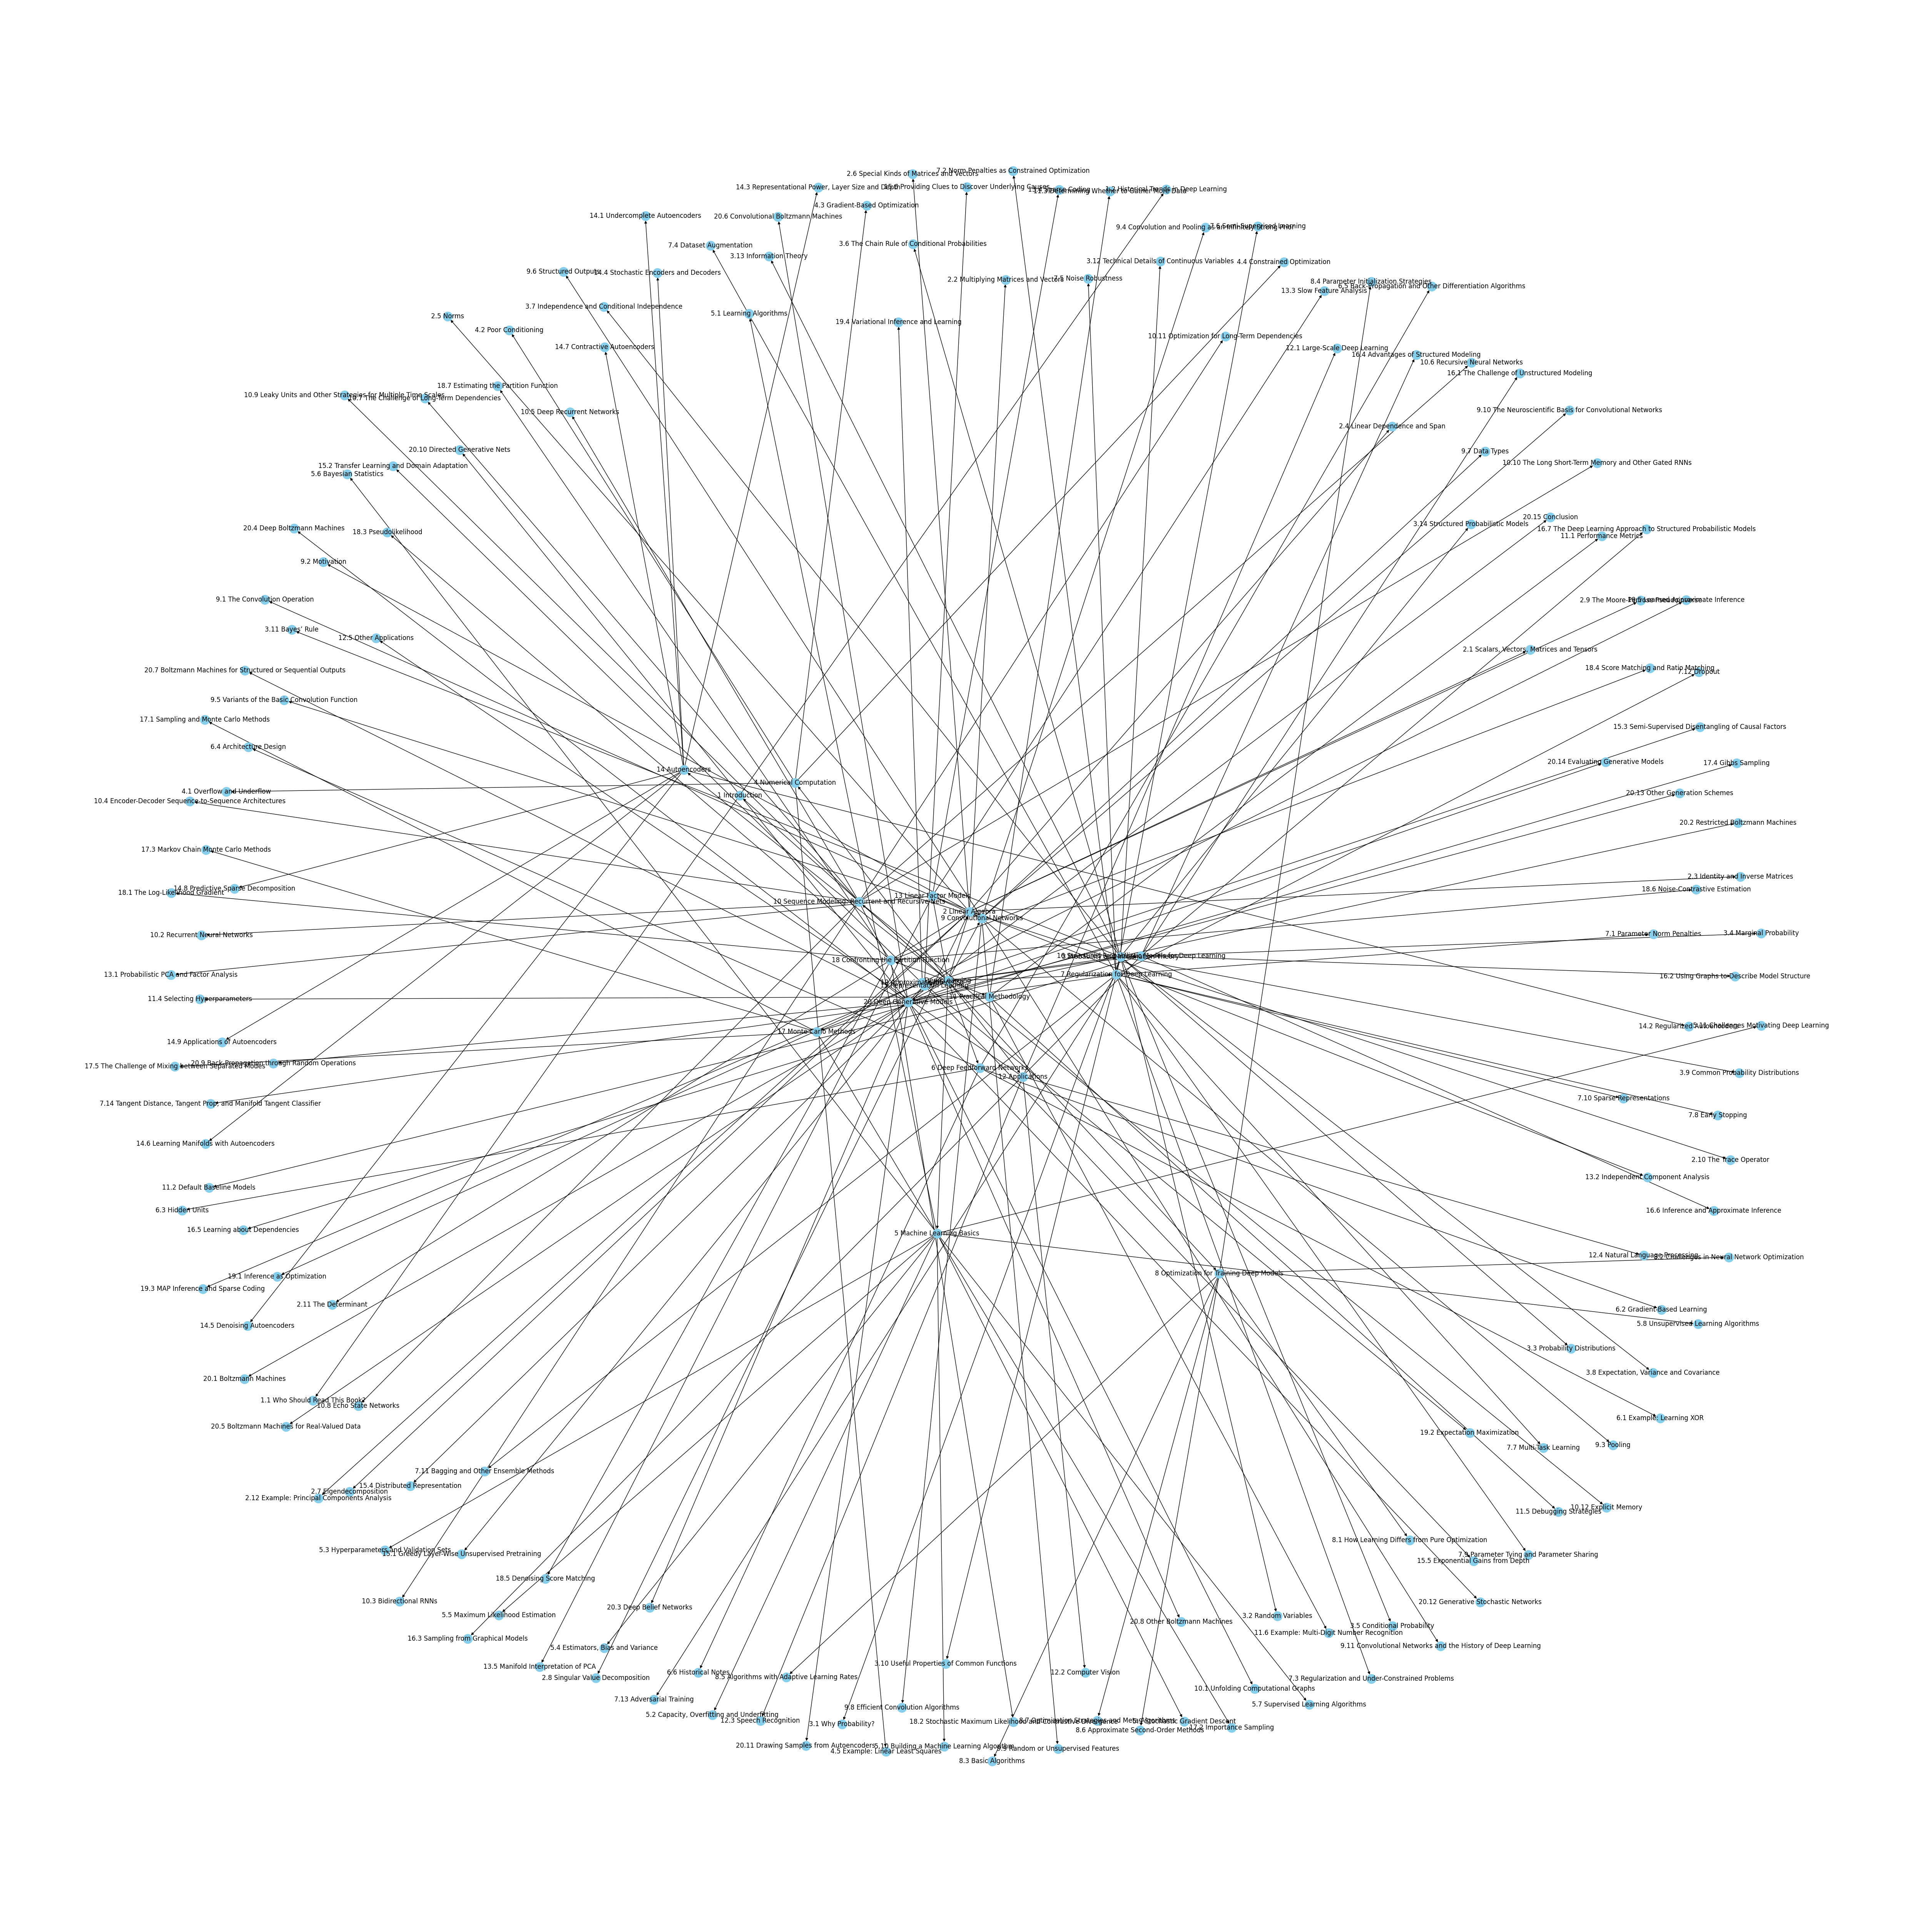

In [268]:
plt.figure(figsize=(50, 50))


pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## 一些其他尝试

### N - Gram

In [33]:
# 暂时没有探索结果
# all_text = re.sub('[^A-Za-z0-9\.]+', ' ', text).lower().split(' ')
# ng1 = collections.defaultdict(int)
# ng2 = collections.defaultdict(int)
# ng3 = collections.defaultdict(int)
# ng4 = collections.defaultdict(int)
# for i, j in enumerate(all_text):
#     ng1[j] += 1
#     if i > 0: ng2[(all_text[i-1], j)] += 1
#     if i > 1: ng3[(all_text[i-2], all_text[i-1], j)] += 1
#     if i > 2: ng4[(all_text[i-3], all_text[i-2], all_text[i-1], j)] += 1

# def sort_feq(dic):
#     return sorted([(k, v) for k, v in dic.items()], key=lambda x: x[1], reverse=True)